In [110]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto-1\\AAA_Thursday1\\data\\__init__.py'>

In [111]:
data = data.load_asset('SOLUSDT', sampling='6h')
# Restrict data after 2022
data = data[data.index >= '2024-01-01']

data

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open time,,,,,,,,,
2024-01-01 00:00:00,101.72,104.75,101.44,101.64,932050.770,9.588012e+07,131715,475769.730,4.894073e+07
2024-01-01 06:00:00,101.64,104.95,101.54,104.32,829602.800,8.582697e+07,102817,410452.290,4.247459e+07
2024-01-01 12:00:00,104.33,108.39,103.86,107.09,1322472.540,1.401078e+08,173450,700757.800,7.427326e+07
2024-01-01 18:00:00,107.09,109.93,107.09,109.91,1319184.260,1.429489e+08,155548,659719.990,7.151609e+07
2024-01-02 00:00:00,109.93,113.20,108.46,112.61,1953632.890,2.173212e+08,249366,1038078.600,1.155180e+08
...,...,...,...,...,...,...,...,...,...
2025-03-30 18:00:00,124.52,127.08,123.19,124.82,452815.503,5.670048e+07,261369,232030.813,2.907739e+07
2025-03-31 00:00:00,124.83,127.63,122.75,126.03,661253.893,8.287883e+07,357500,324047.545,4.062794e+07
2025-03-31 06:00:00,126.04,127.08,123.05,124.28,759145.971,9.477851e+07,371746,344733.075,4.310196e+07


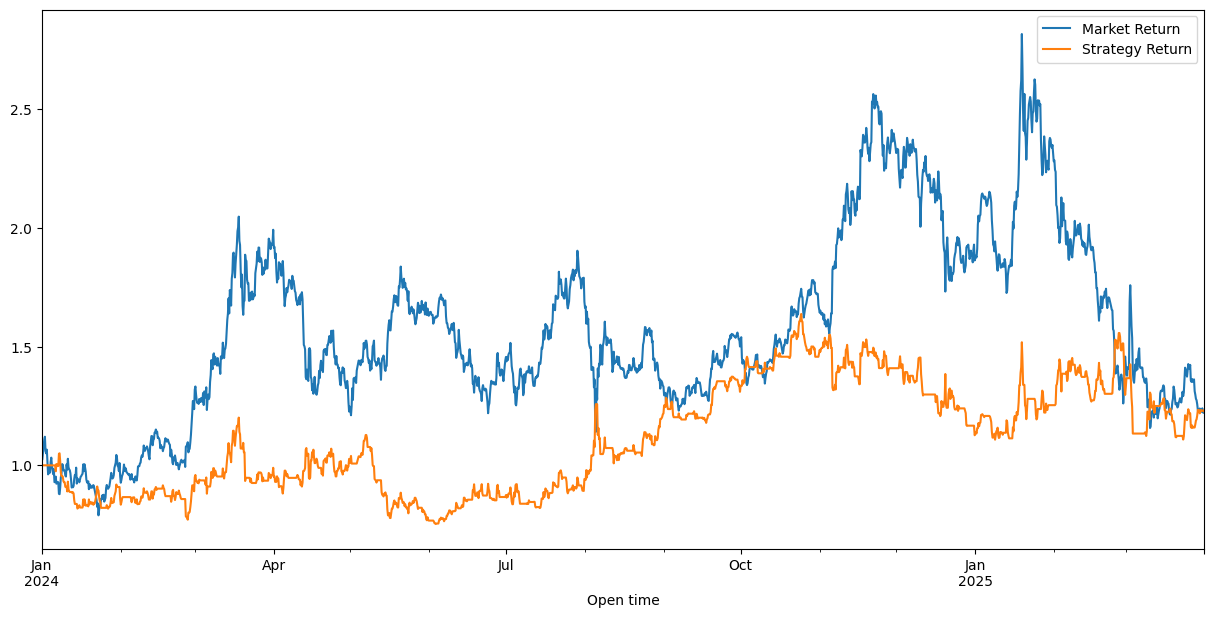

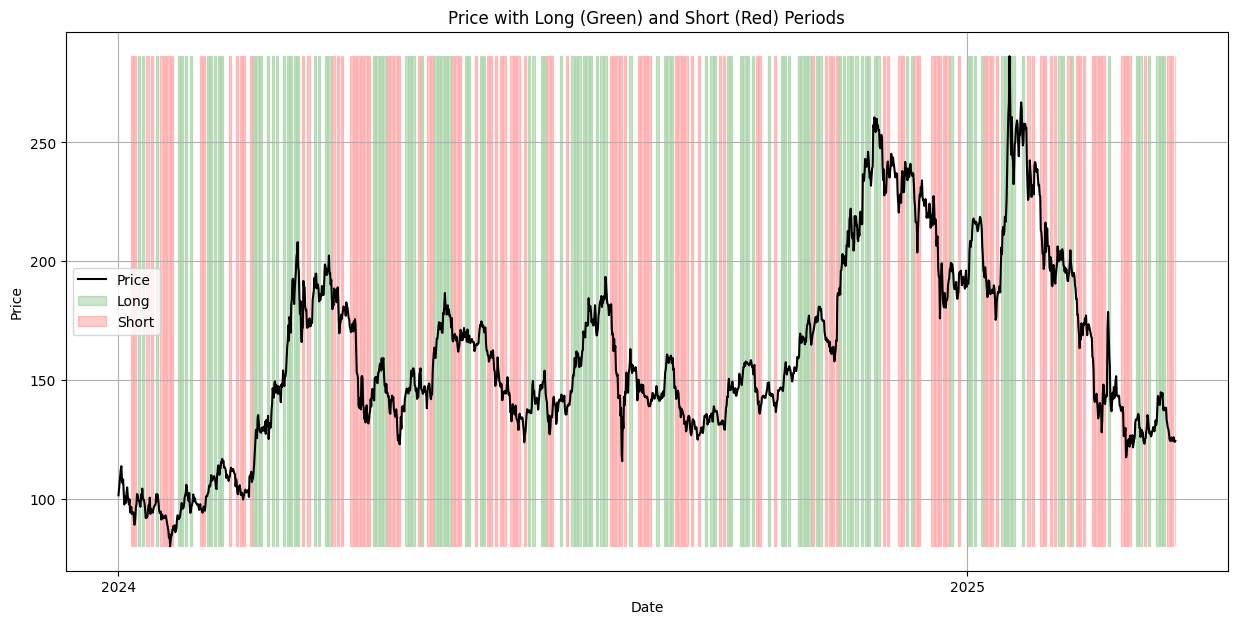

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

price = data['Close']

# Moving average and std
window = 20
moving_avg = price.rolling(window=window).mean()
moving_std = price.rolling(window=window).std()

# Z-score
z_score = (price - moving_avg) / moving_std

# Threshold
threshold = 1


# Parameters
exit_after_days = 5  # Exit after 5 days
position = []        # To manually build positions

current_position = 0
days_in_position = 0

# Step through each day
for i in range(len(z_score)):
    if current_position == 0:
        if z_score.iloc[i] < -threshold:
            current_position = -1  # Long
            days_in_position = 1
        elif z_score.iloc[i] > threshold:
            current_position = 1  # Short
            days_in_position = 1
        else:
            current_position = 0
    else:
        days_in_position += 1
        if days_in_position > exit_after_days:
            current_position = 0
            days_in_position = 0
    
    position.append(current_position)

# Add position to dataframe
data['Position'] = position

# Shift position for returns
data['Position'] = data['Position'].shift(1)

# Calculate returns
data['Market Return'] = price.pct_change()
data['Strategy Return'] = data['Position'] * data['Market Return']

# Cumulative returns plot
(1 + data[['Market Return', 'Strategy Return']]).cumprod().plot(figsize=(15,7))
import matplotlib.dates as mdates

# Plot
fig, ax = plt.subplots(figsize=(15,7))

# Plot the price
ax.plot(data.index, price, label='Price', color='black')

# Shade LONG periods
long_periods = data['Position'] == 1
ax.fill_between(data.index, price.min(), price.max(), 
                where=long_periods, color='green', alpha=0.2, label='Long')

# Shade SHORT periods
short_periods = data['Position'] == -1
ax.fill_between(data.index, price.min(), price.max(), 
                where=short_periods, color='red', alpha=0.2, label='Short')

# Formatting
ax.set_title('Price with Long (Green) and Short (Red) Periods')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()



In [113]:
data["Position"].sum()

np.float64(18.0)

KeyError: 'Position'

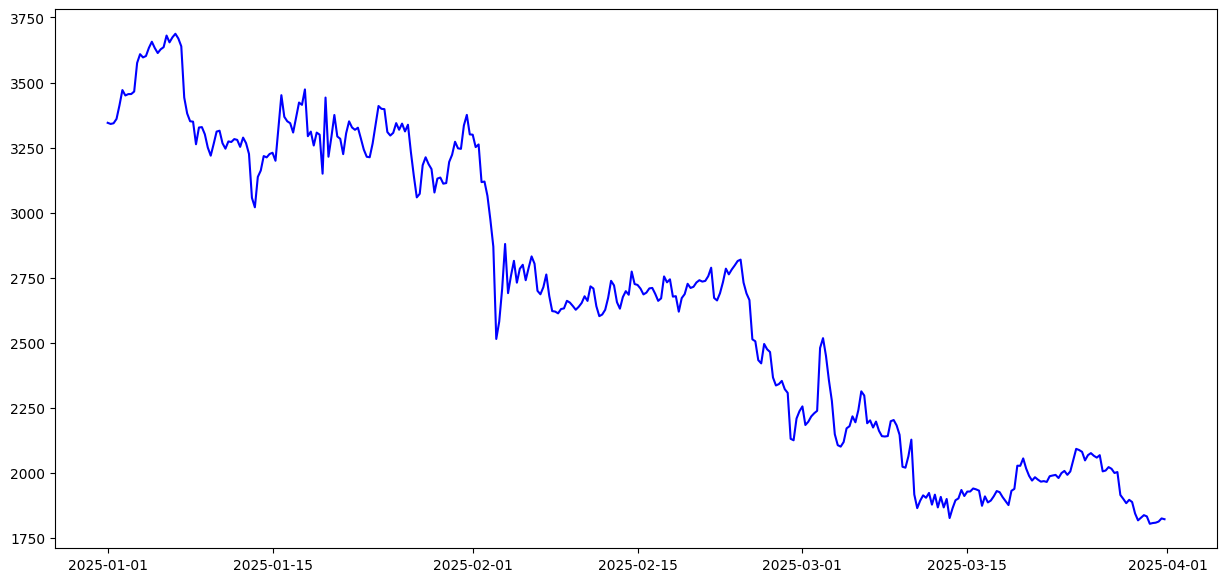

In [114]:
import matplotlib.pyplot as plt

# Plot setup
plt.figure(figsize=(15,7))

# Plot price
plt.plot(sol_1d.index, sol_1d['Close'], label='Price', color='blue')

# Highlight long days
long_days = sol_1d['Position'] == 1
plt.scatter(sol_1d.index[long_days], sol_1d['Close'][long_days], 
            label='Long Position', color='green', marker='o', s=50)

# Titles and labels
plt.title('Price Movement with Long Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


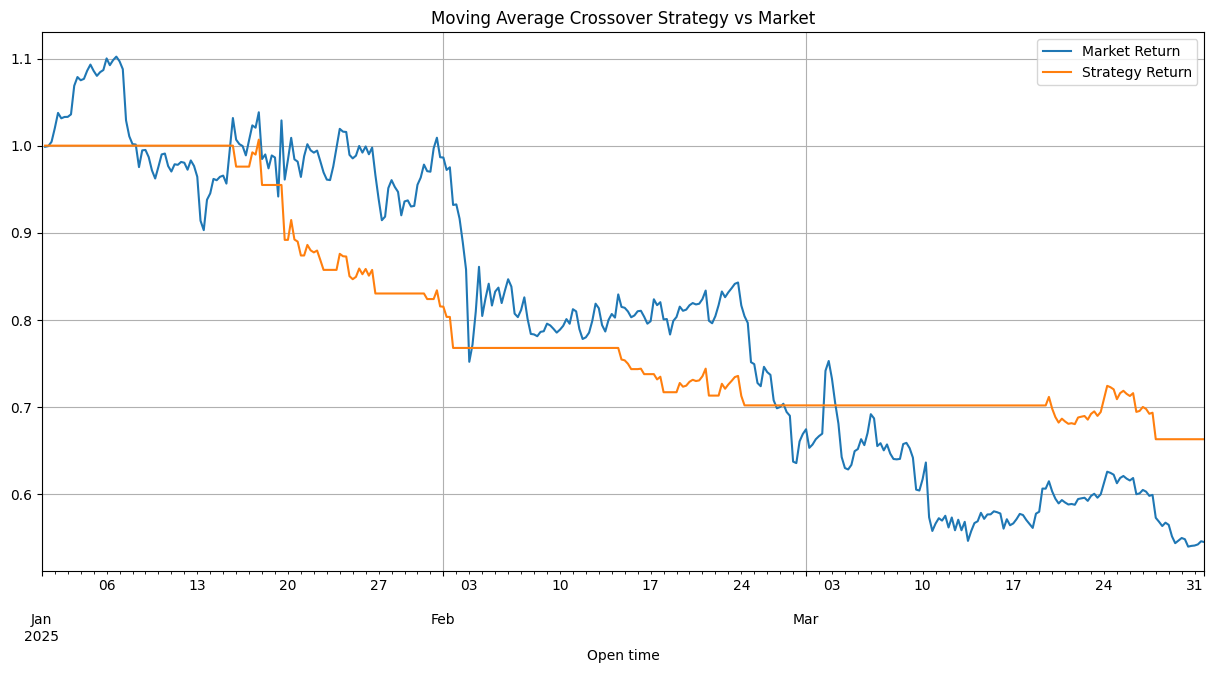

In [ ]:
price = data['Close']

# Calculate Moving Average
window = 50  # e.g., 50 days
sma = price.rolling(window=window).mean()

# Trading signals
data['Position'] = 0
data['SMA'] = sma

# Buy signal: price crosses above SMA
data.loc[price > sma, 'Position'] = 1

# Sell signal: price crosses below SMA
data.loc[price <= sma, 'Position'] = 0

# Shift position for returns
data['Position'] = data['Position'].shift(1)

# Returns
data['Market Return'] = price.pct_change()
data['Strategy Return'] = data['Position'] * data['Market Return']

# Plot cumulative returns
(1 + data[['Market Return', 'Strategy Return']]).cumprod().plot(figsize=(15,7))
plt.title('Moving Average Crossover Strategy vs Market')
plt.grid(True)
plt.show()

